In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import re
from IPython.core.display import HTML
import os
import random

DATA_FOLDER = '/Users/KhalilCherif/Desktop/ada/ADA2017-Tutorials/02 - Intro to Pandas/Data/'

HTML(filename=DATA_FOLDER+'/titanic.html')
data = pd.read_excel(DATA_FOLDER+"/titanic.xls")
df1 = pd.DataFrame({'attribute': list(data),'type':list(data.dtypes)})
%matplotlib inline

In [103]:
sns.set_context('notebook')

DATA_FOLDER = '/Users/KhalilCherif/Desktop/ada/ADA2017-Tutorials/02 - Intro to Pandas/Data'
os.chdir(DATA_FOLDER)

In [121]:
HTML(filename=DATA_FOLDER+'/titanic.html')

Question 1: In the next 4 celles w load the data into data and create df1, a dataframe with index equal to the columns of data and with one column containing the data type of every column

In [105]:
data = pd.read_excel(DATA_FOLDER+'/titanic.xls')

In [106]:
df1 = pd.DataFrame({'attribute': list(data.columns),'type':list(data.dtypes)})

In [107]:
data.select_dtypes(exclude=[object]).min().index

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'body'], dtype='object')

In [108]:
df1.set_index('attribute', inplace=True)

We added a column for the min value and max value for every attribute different of object (meaning float64 and int64)

In [109]:
df1.loc[data.select_dtypes(exclude=[object]).min().index,'Min']=data.select_dtypes(exclude=[object]).min()

In [110]:
df1.loc[data.select_dtypes(exclude=[object]).max().index,'Max']=data.select_dtypes(exclude=[object]).max()

Here we change the type of every column with less than 9 different elements

In [111]:
ind = [elem for elem in data.columns if data[elem].nunique()<9]
for elem in ind:
    data[elem]=data[elem].astype('category')
    

Question 2: We now plot the histograms of class, embarked, sex and age in the first, second, third and fourth histograms respectiveley

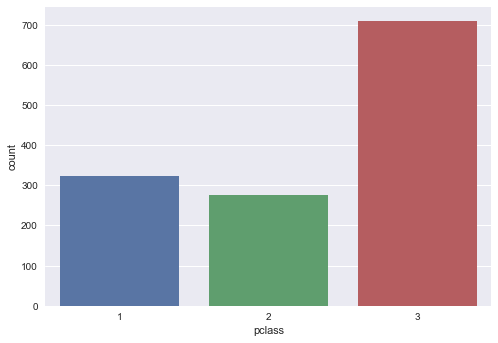

In [112]:
sns.countplot(x='pclass', data=data)

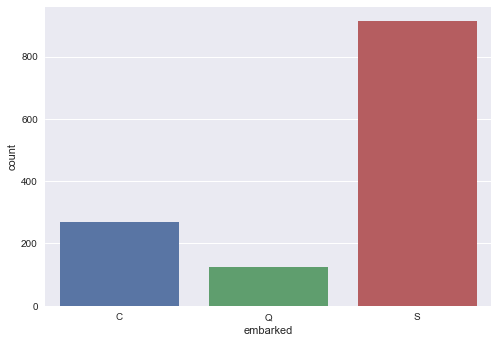

In [113]:
sns.countplot(data=data, x='embarked')

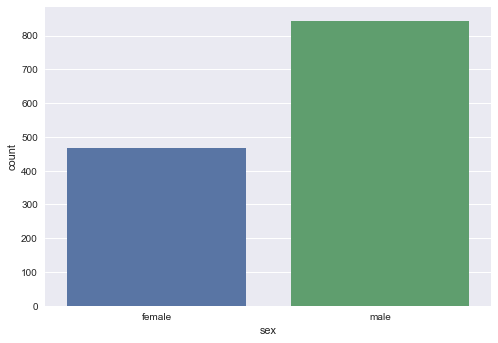

In [114]:
sns.countplot(data=data, x='sex')

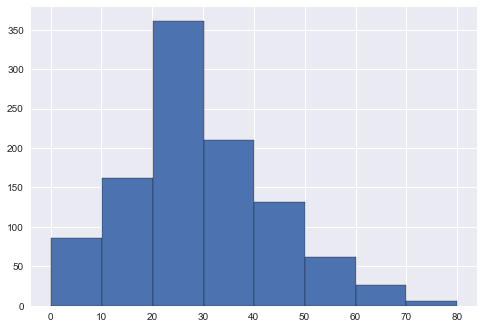

In [119]:
#We calculate the length of the interval of the ages, then divide it by 10 to get the number of bins we will use.
from math import ceil
data['age'].hist(bins=ceil((data['age'].max()-data['age'].min())/10), ec='black')

This histogram is just made to visualize if there is a difference of the number of survivors within a same class

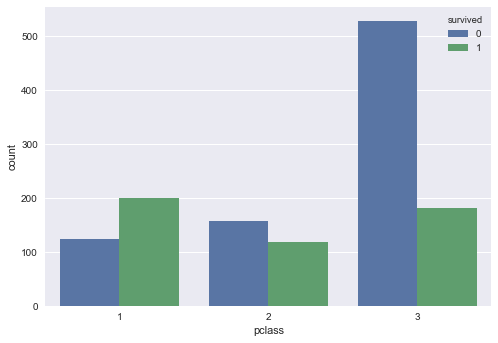

In [116]:
sns.countplot(data=data, hue='survived', x='pclass')

Question 3: We have noticed in our data that some cabines were put as a range of cabins for a family. 
For a group, in the cabin column we have distinct cabin as a single string. 
So we used this code to add every cabin in the range, for example if we have C34-C37 we add in a new array final_cab the cabins C34,C35,C36,C37. 
For a group we just split the string and add distinct cabine in the final array. 

In [117]:
cabin1 = data['cabin'].dropna()
#final_cab is the array where we will have all the cabins after handling ranges and distinct 
#values(there are duplicates in it). 

final_cab = []

i = 0
for elem in cabin1:
        if (len(elem.split())>1):
            tmp = re.findall("\d+", elem)
            #here we handle the range
            if (len(tmp) == 2):
                tmp[0] = int(tmp[0])
                tmp[1] = int(tmp[1])
                tmp2 = list(range(tmp[0],tmp[1]+1))
                for elem2 in tmp2:
                    final_cab.append(elem[0] + str(elem2))
            if (len(tmp) > 2):
                #here we handle the distinct case
                for elem3 in elem.split():
                    final_cab.append(elem3)
        else: 
            #here we just add the single cabin case (travial one)
                final_cab.append(elem)
        i=i+1


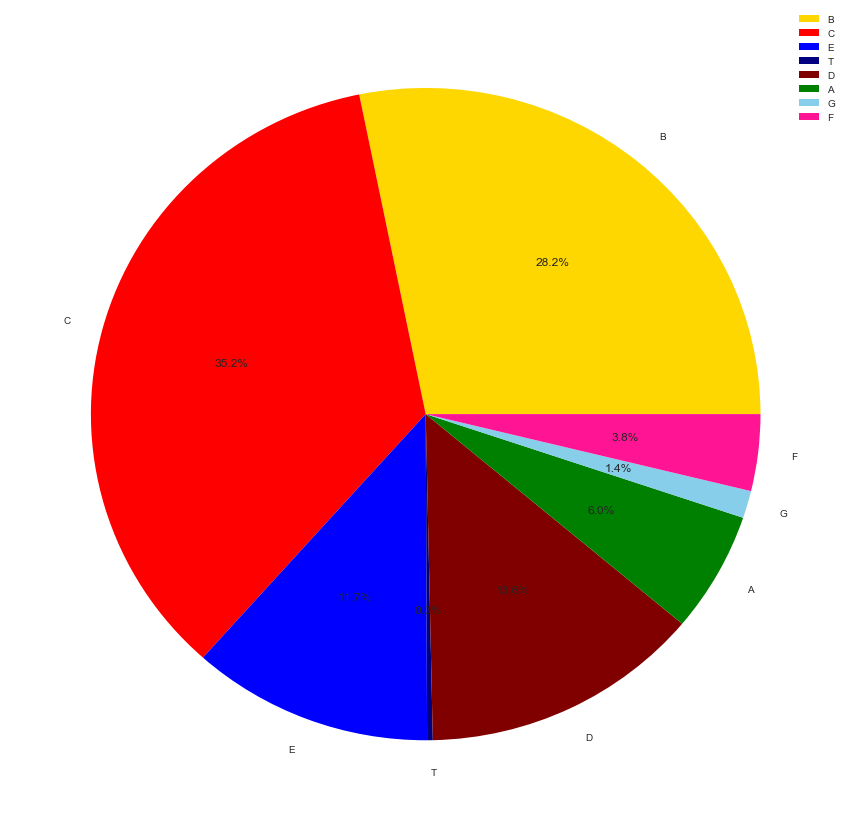

In [118]:
#here we make sure that we have an array of unique cabins, so that we can count the proportion
#of passengers by cabin. 

distinct_cab_proportion = pd.DataFrame()
#distinct_cab_proportion is the resulting dataframe. 
final_cab_distinct = []
#final_cab_distinct contains the distinct cabins that we have. 

for elem in final_cab:
    final_cab_distinct.append(elem[0])
final_cab_distinct = list(set(final_cab_distinct))

length = len(final_cab_distinct)
zeros = np.zeros(length)

for elem in final_cab: 
    ind = 0
    for elem2 in final_cab_distinct:
        if elem[0] == elem2:
            zeros[ind] = zeros[ind] + 1
        ind=ind+1

distinct_cab_proportion['Cabin_floor'] = final_cab_distinct
distinct_cab_proportion['Number_of_persons'] = zeros/len(final_cab)

#plots
colors = ['gold', 'red', 'blue', 'navy', 'maroon', 'green', 'skyblue', 'deeppink']

fig = plt.figure(figsize=(15,15))

plt.pie(distinct_cab_proportion['Number_of_persons'], labels = distinct_cab_proportion['Cabin_floor'], colors=colors,autopct='%1.1f%%')
plt.legend(distinct_cab_proportion['Cabin_floor'])

Question 4: For the next 2 cells we calculate the survival rate by class

In [74]:
classes = data['pclass'].unique()
proportion_survived_by_class = [data.loc[data['pclass']==cls,'survived'].astype('int').mean() for cls in classes]

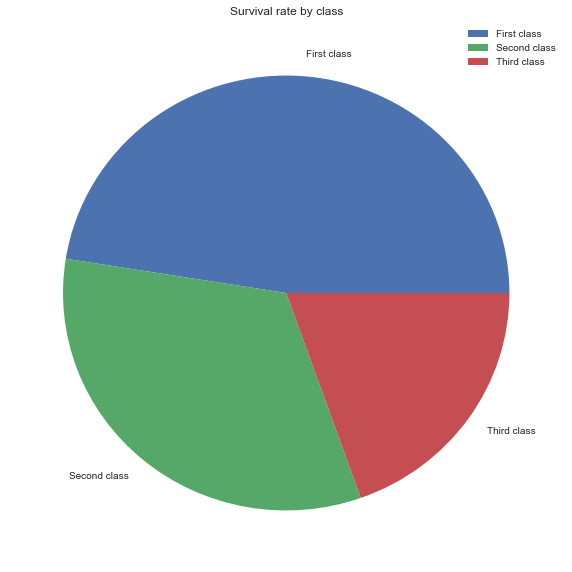

In [75]:
fig = plt.figure(figsize=(10,10))
plt.pie(proportion_survived_by_class, labels='First class,Second class,Third class'.split(','))
plt.title('Survival rate by class')
plt.legend('First class,Second class,Third class'.split(','), loc=1)

In the next 2 cells we create df_class_sex which contains the cartesian product of the set of classe and the set of sex

In [76]:
df_class = pd.DataFrame({'pclass':data['pclass'].unique(), 'key': np.zeros(data['pclass'].nunique())})
df_sex = pd.DataFrame({'key': np.zeros(data['sex'].nunique()), 'sex': data['sex'].unique()})

In [79]:
df_class_sex = pd.merge(df_class, df_sex, on = 'key')[['pclass', 'sex']]

In the next cell, we iterate over df_class_sex, filtering the rows by the sex and the class in which our iterator is,
we then calculate the survivale rate and the number of survivors for every couple of class and sex that we put in a
3-tuple, we then set the index of the table to sex/class

In [82]:
df_mean_class_sex = pd.DataFrame([('{}/{}'.format(df_class_sex.iloc[i,1],df_class_sex.iloc[i,0].astype('str')),data.loc[(data['pclass']==df_class_sex.iloc[i,0]) & (data['sex']==df_class_sex.iloc[i,1]),'survived'].astype('int').mean(),data.loc[(data['pclass']==df_class_sex.iloc[i,0]) & (data['sex']==df_class_sex.iloc[i,1]),'survived'].astype('int').sum()) for i in range(df_class_sex.shape[0])], columns='sex/class,survival rate,number of survivors'.split(','))


df_mean_class_sex.set_index('sex/class', inplace=True)

We wanted to show the difference between the suvival rate among a class vs the proportion of suvivor of one class amongst all suvivors, clearly it is not the same thing as these 2 plots show us. Even though there is more males from third class that survived than from 2nd class, the survival rate of mens of 1st class is far better than in the 3rd class

<Container object of 6 artists>

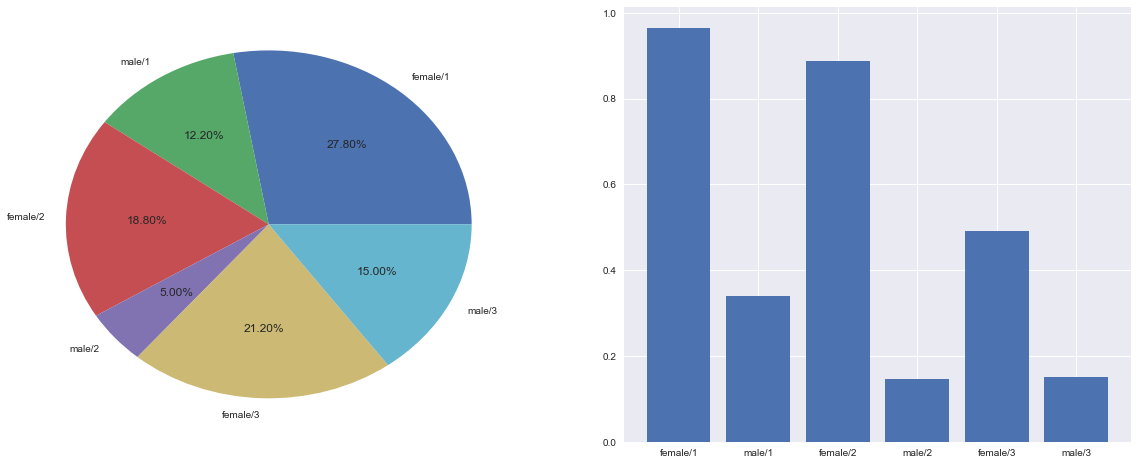

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].pie(df_mean_class_sex['number of survivors'], labels = df_mean_class_sex.index, autopct='%1.2f%%')
axes[1].bar(height=df_mean_class_sex['survival rate'], left=range(len(df_mean_class_sex['survival rate'])), tick_label = df_mean_class_sex.index)

Question 5: Histogram of suvival rate by class and sex (female/1 means sex: female, class: 1st for example)

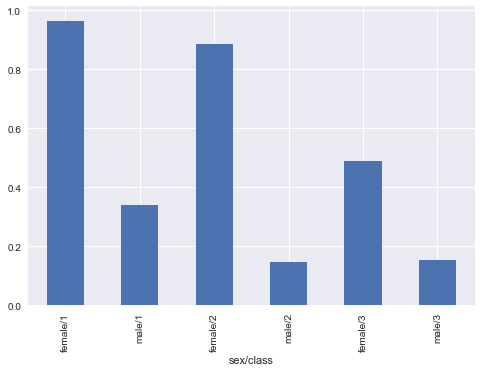

In [86]:
df_mean_class_sex['survival rate'].plot(kind='bar')

Question 6: We start by creating a DataFrame containing the cartesian product of class, sex and age category.
Age category was constructed by droping all the na values, selecting the correponding rows from data, creating a column age category in which you are in category 0 if you are under 28 (the 50% quantile) and 1 otherwise.

Using the 50% quantile splitted the data into 2 age categories of length 510 and 536, which we consider as "equally" populated. This choice was the most natural choice for us.

In [94]:
df_class_sex['key']=np.zeros(len(df_class_sex.index))

In [95]:
df_class_sex_age_cat = pd.merge(left=df_class_sex, right=pd.DataFrame({'age category':pd.Series([0,1]), 'key':np.zeros(2)}), on='key')['sex,pclass,age category'.split(',')]


In [96]:
our_indexes = data['age'].dropna().index

In [97]:
new_data = data.loc[our_indexes, 'survived sex pclass age'.split()]

In [98]:
new_data['age category']=new_data['age'].apply(lambda x: 0 if x <= 28 else 1)

Here we calculate the survival rate and the number of survivors for each sex/class/age category set-up using the same logic as the precedent question and loading everything into a DataFrame

In [99]:
avg_class_sex_age_cat = pd.DataFrame([('{}/{}/{}'.format(df_class_sex_age_cat.loc[i,'sex'], df_class_sex_age_cat.loc[i,'pclass'],df_class_sex_age_cat.loc[i,'age category']), new_data.loc[(new_data['sex']==df_class_sex_age_cat.loc[i,'sex'])&(new_data['pclass']==df_class_sex_age_cat.loc[i,'pclass'])&(new_data['age category']==df_class_sex_age_cat.loc[i,'age category']),'survived'].astype('int').mean(),new_data.loc[(new_data['sex']==df_class_sex_age_cat.loc[i,'sex'])&(new_data['pclass']==df_class_sex_age_cat.loc[i,'pclass'])&(new_data['age category']==df_class_sex_age_cat.loc[i,'age category']),'survived'].astype('int').sum()) for i in range(df_class_sex_age_cat.shape[0])], columns='sex/class/age category,survival rate,number of survivors'.split(','))


avg_class_sex_age_cat.set_index(keys=['sex/class/age category'], inplace=True)



In [43]:
avg_class_sex_age_cat

survival rate  number of survivors
sex/class/age category                                    
female/1/0                   0.951220                   39
female/1/1                   0.967391                   89
male/1/0                     0.531250                   17
male/1/1                     0.302521                   36
female/2/0                   0.910714                   51
female/2/1                   0.872340                   41
male/2/0                     0.216216                   16
male/2/1                     0.083333                    7
female/3/0                   0.513761                   56
female/3/1                   0.372093                   16
male/3/0                     0.183036                   41
male/3/1                     0.144000                   18